**This notebook includes the following sections:**

**#01** Importing libraries and data

**#02** Wrangling data

**#03** Decomposition

**#04** Dickey-Fuller Stationarity Test

**#05** Stationarizing data

**#06** Checking for autocorrelations

**#01 Importing libraries and data**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings
import nasdaqdatalink
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [4]:
#Defining API key
nasdaqdatalink.ApiConfig.api_key = 'xooEY-Gz8yeYA1Sqcibp'

In [6]:
#Pulling data
data = nasdaqdatalink.get_table('ZILLOW/DATA',indicator_id='ZSFH', region_id=[90754, 90755, 90756])

In [7]:
type(data)

pandas.core.frame.DataFrame

In [8]:
data.columns

Index(['indicator_id', 'region_id', 'date', 'value'], dtype='object')

In [9]:
data.shape

(1022, 4)

In [10]:
df = data.drop(columns = 'indicator_id')

In [11]:
df.dtypes

region_id            object
date         datetime64[ns]
value               float64
dtype: object

In [12]:
#Creating a version of the data with only the date and value so I can plot it
df_plot = df[['date', 'value']]

Text(0, 0.5, 'Value')

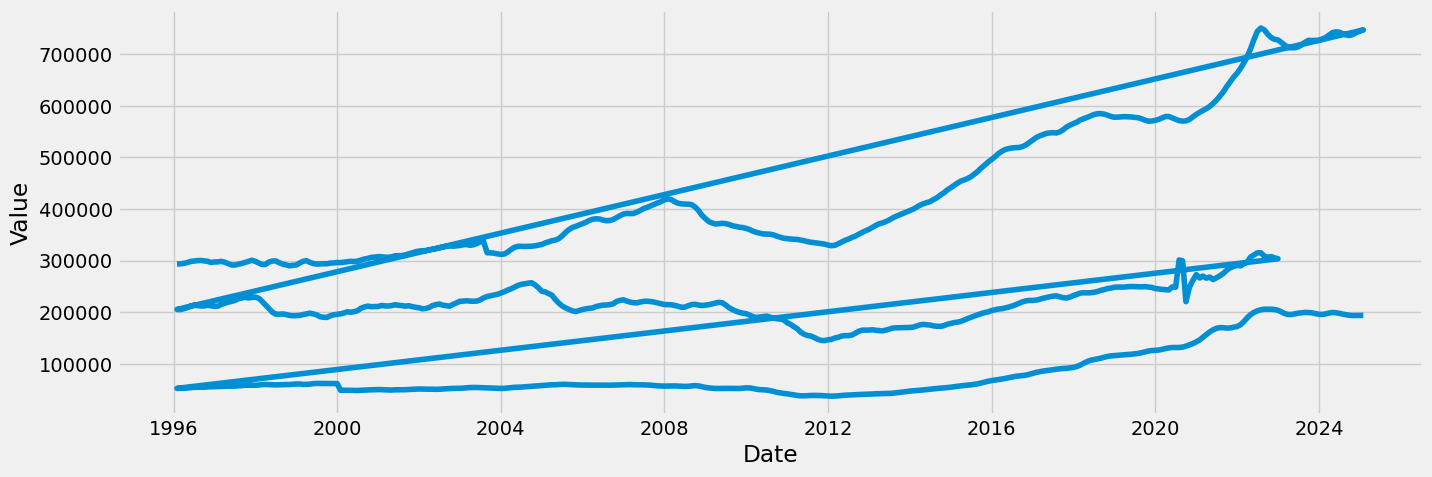

In [13]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_plot['date'], df_plot['value'])
plt.xlabel('Date')
plt.ylabel('Value')

**#02 Wrangling, subsetting, and cleaning data**

In [15]:
#I only want data from 2007 and later, since Airbnb was founded in 2007. So let's filter the dataframe...
df_2 = df.loc[df['date'] >= '2007-01-01']

In [16]:
#Now let's set the date column as the index. It's already in datetime format.
df_2 = df_2.set_index('date')

In [17]:
df_2.head()

region_id          value
date                               
2025-01-31     90756  193681.031011
2024-12-31     90756  193524.993642
2024-11-30     90756  193331.881935
2024-10-31     90756  193339.812868
2024-09-30     90756  193797.828106

Text(0, 0.5, 'Value')

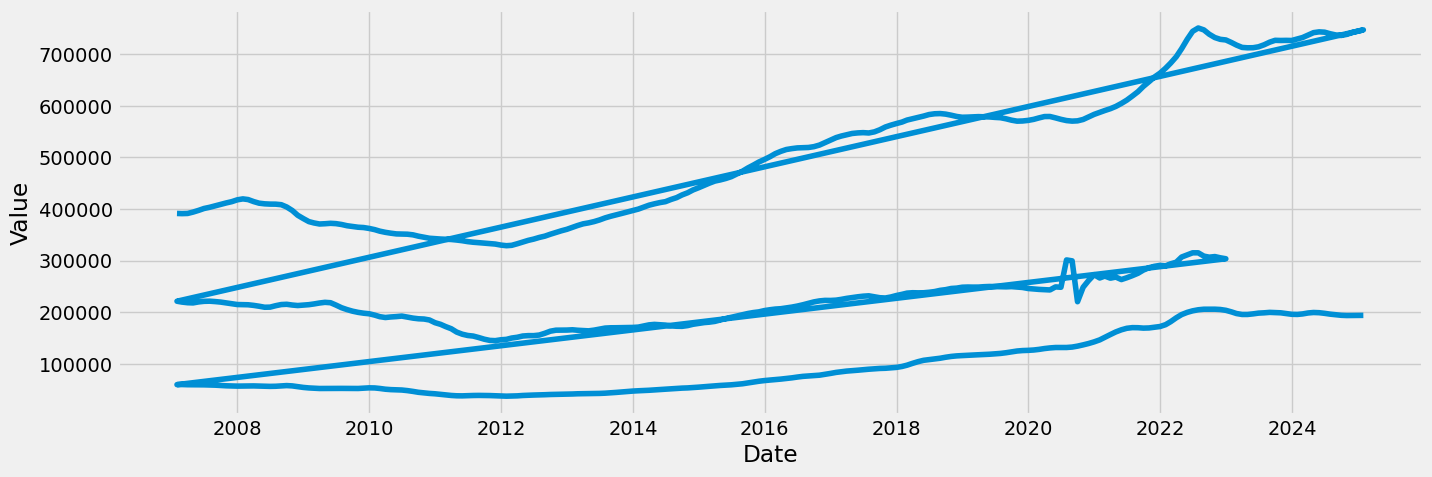

In [18]:
#Plotting the new filtered dataset
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_2['value'])
plt.xlabel('Date')
plt.ylabel('Value')

In [19]:
#Checking for missing values
df_2.isnull().sum()

region_id    0
value        0
dtype: int64

In [20]:
#Checking for duplicates
dupe = df_2.duplicated()
dupe.sum()

1

In [21]:
df_2[dupe]

region_id     value
date                          
2019-03-31     90755  248542.0

In [22]:
df_final = df_2.drop_duplicates()

In [23]:
df_final.shape

(625, 2)

**#03 Decomposition**

In [25]:
df_final = df_final.sort_index()

In [26]:
#Since my data looks pretty linear, we'll decompose using the additive model.
decomposition = sm.tsa.seasonal_decompose(df_final['value'], model='additive', period=12)

In [27]:
#Defining a fixed size for all special charts
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

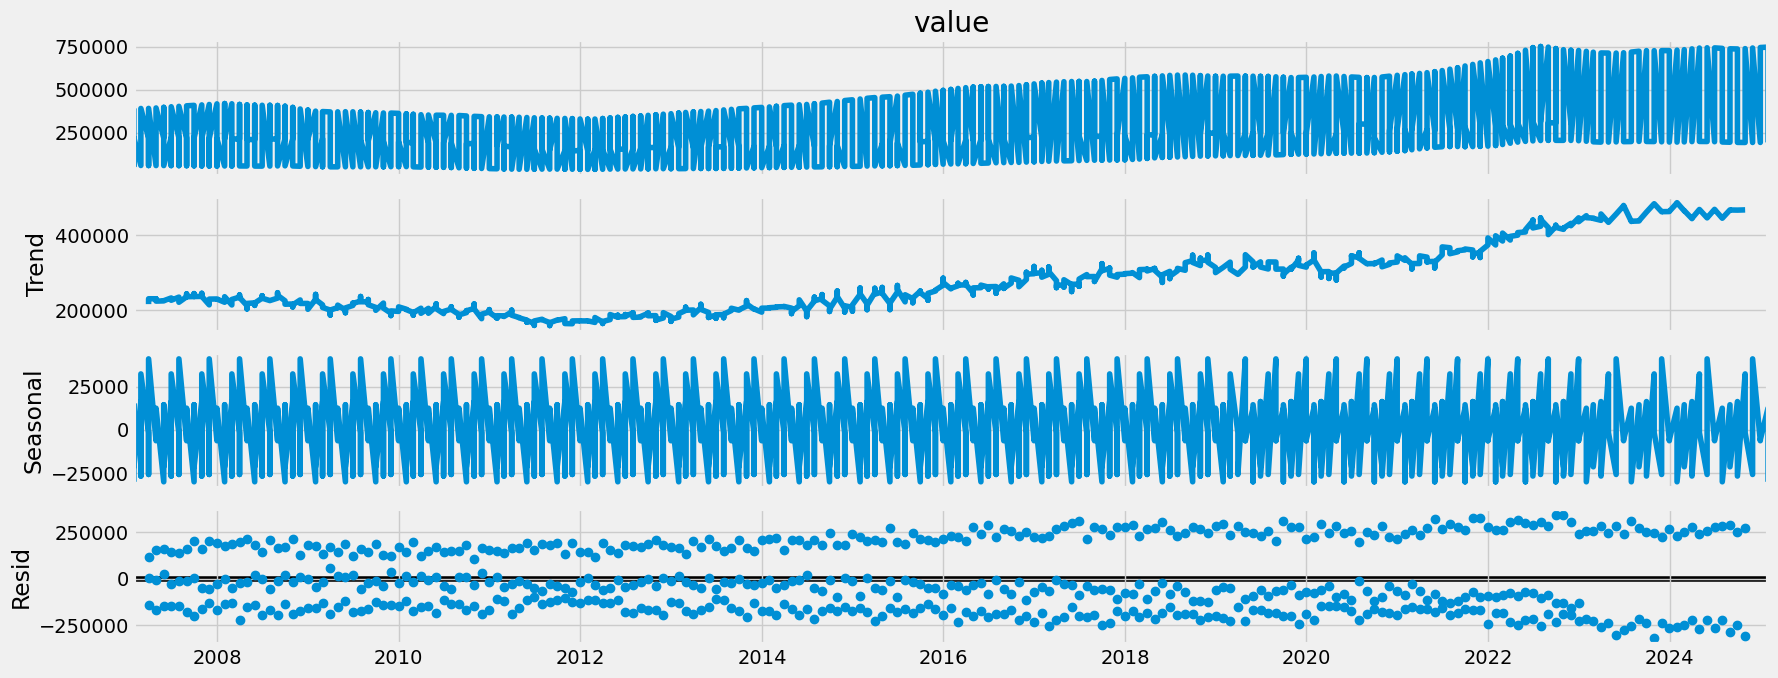

In [28]:
#Now we plot the components
decomposition.plot()
plt.show()

**Trend** According to this plot, single-family home values are trending upwards over time, especially since 2022. This tracks, as the COVID-19 pandemic slowed homebuying for a little while (hence the slight dip between 2020 and 2022). However, once the pandemic's effects began to wane, the housing market went up like crazy.

**Seasonality** There does appear to be some kind of seasonal trend from year to year. It's disrupted around 2019, settles into a new rhythm around 2020, and then changes again sometime around the end of 2023.

**Overall** There is a definite trend upward for the value of single-family homes in Dallas, TX.

**#04 Dickey-Fuller Stationarity Test**

In [55]:
#Importing the function I need
from statsmodels.tsa.stattools import adfuller

#Defining a dickey-fuller function
def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

#Applying the defined function to my dataset
dickey_fuller(df_final['value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.273907
p-value                          0.996459
Number of Lags Used             19.000000
Number of Observations Used    605.000000
Critical Value (1%)             -3.441205
Critical Value (5%)             -2.866329
Critical Value (10%)            -2.569320
dtype: float64


Using a significance level of 5%, I am unable to reject my null hypothesis--in this case, I cannot disprove the existence of a unit root. Therefore, my data is not stationary. 

**#05 Stationarizing data**

In [76]:
#I found out the region_id variable was an object instead of numerical. Let's switch it real quick...
df_final['region_id'] = df_final['region_id'].astype(int)

In [80]:
#Differencing
df_diff = df_final - df_final.shift(1)

In [84]:
#Dropping null values
df_diff.dropna(inplace = True)

In [86]:
df_diff.head()

region_id          value
date                                
2007-01-31        2.0 -332066.651404
2007-01-31       -1.0  161818.240400
2007-02-28        1.0 -161650.872876
2007-02-28       -1.0  159955.872876
2007-02-28       -1.0  171601.533245

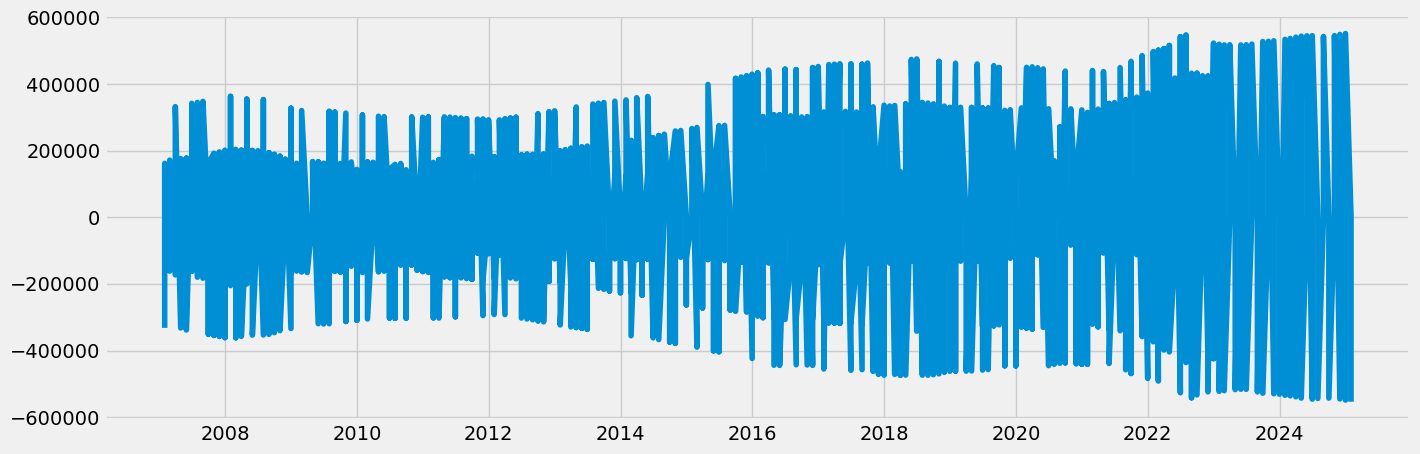

In [88]:
#Let's check the plot
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff['value'])

In [94]:
#It certainly appears more stationary. Let's run the dickey_fuller function again to check.
dickey_fuller(df_diff['value'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.174620e+01
p-value                        1.239787e-21
Number of Lags Used            1.900000e+01
Number of Observations Used    6.040000e+02
Critical Value (1%)           -3.441223e+00
Critical Value (5%)           -2.866337e+00
Critical Value (10%)          -2.569325e+00
dtype: float64


Using a significance level of 5%, my test statistic is now smaller than my critical value. This means I can reject the null hypothesis. In other words, there is no unit root and my data is now stationary.

**#06 Checking for autocorrelations**

In [99]:
#Importing plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Plotting autocorrelations
plot_acf(df_diff['value'])
plt.show()

Looks like my data has very strong stationarity! There are only two lags correlated with each other.